# An environmental layers testing framework for the FAO land cover classification system

The purpose of this notebook is to provide an easy-to-use method for testing environmental layers to use for classification and seeing how changes to particular layers effect the final Land Cover Classification. You can easily test with different environmental layer inputs, and different locations. 

This code defines 5 variables to contain the binary layers required to reach a level 3 classification:
1. **vegetat_veg_cat:** Vegetated / Non-Vegetated 
2. **aquatic_wat_cat:** Water / Terrestrial 
3. **cultman_agr_cat:** Natural Veg / Crop or Managed Veg
4. **artific_urb_cat:** Natural Surfaces / Artificial Surfaces (bare soil/urban) 
5. **artwatr_wat_cat:** Natural water / Artificial water

Whilst this example is using open data cube to load the required data, it can be loaded from anywhere - so long as all input layers cover the same geographic region and are defined in a correctly labelled dataset, before being passed to the classification code.


In [3]:
import numpy
import xarray
import scipy
from matplotlib import pyplot
from matplotlib import cm
import datacube
from datacube.storage import masking
dc = datacube.Datacube(app="le_lccs")

#import classification script
import lccs_l3
dc.list_products()

,name,description,format,lat,creation_time,time,product_type,label,platform,lon,instrument,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
15,alos2_palsar_AMA_ingest,ALOS-2 PALSAR mosaic tiles generated for use i...,GeoTIFF,None,None,None,gamma0,None,ALOS_2,None,PALSAR,NaN,NaN,NaN,NaN
6,ls5_level1_usgs,Landsat 5 USGS Level 1 Collection-1 OLI-TIRS,GeoTiff,None,None,None,L1TP,None,LANDSAT_5,None,TM,NaN,NaN,NaN,NaN
19,ls5_usgs_sr_scene,Landsat 5 USGS Collection 1 Level2 Surface Ref...,GeoTiff,None,None,None,LEVEL2_USGS,None,LANDSAT_5,None,TM,NaN,NaN,NaN,NaN
17,ls7_collection1_AMA_ingest,Landsat 7 USGS Collection 1 Higher Level SR sc...,GeoTiff,None,None,None,LEDAPS,None,LANDSAT_7,None,ETM,NaN,NaN,NaN,NaN
5,ls7_level1_usgs,Landsat 7 USGS Level 1 Collection-1 OLI-TIRS,GeoTiff,None,None,None,L1TP,None,LANDSAT_7,None,ETM,NaN,NaN,NaN,NaN
18,ls7_usgs_sr_scene,Landsat 7 USGS Collection 1 Level2 Surface Ref...,GeoTiff,None,None,None,LEVEL2_USGS,None,LANDSAT_7,None,ETM,NaN,NaN,NaN,NaN
16,ls8_collection1_AMA_ingest,Landsat 8 USGS Collection 1 Higher Level SR sc...,GeoTIFF,None,None,None,LaSRC,None,LANDSAT_8,None,OLI_TIRS,NaN,NaN,NaN,NaN
7,ls8_l1_pc_usgs,Landsat 8 USGS Level 1 Pre-Collection OLI-TIRS,GeoTiff,None,None,None,L1T,None,LANDSAT_8,None,OLI_TIRS,NaN,NaN,NaN,NaN
4,ls8_level1_usgs,Landsat 8 USGS Level 1 Collection-1 OLI-TIRS,GeoTiff,None,None,None,L1TP,None,LANDSAT_8,None,OLI_TIRS,NaN,NaN,NaN,NaN


Define details of data to be loaded - area, resolution, crs..

In [4]:
# Define area of interest

# Fiji
x = (178.281, 178.655)
y = (-17.91, -18.1732)

# small Fiji
res = (-30,30)
crs = "EPSG:4326"

query=({'x':x,
        'y':y,
        'crs':crs,
        'resolution':res,
        'time': ("2018-04-02", "2019-03-30")})

out_filename = "Fiji-Suva.tif"

## Create environmental layers

### Presence/Absence of Vegetation

INITIAL-LEVEL DISTINCTION

   * *Primarily Vegetated Areas*:
   This class applies to areas that have a vegetative cover of at least 4% for at least two months of the year, consisting of Woody (Trees, Shrubs) and/or Herbaceous (Forbs, Graminoids) lifeforms, or at least 25% cover of Lichens/Mosses when other life forms are absent.
   * *Primarily Non-Vegetated Areas*:
   Areas which are not primarily vegetated.
 

Here we're using Fractional cover annual percentiles to distinguish between vegetated and not. 
http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover


**Creating your own layer**: To use a different veg/non-veg layer, replace the following two cells with code to create a binary layer with vegetated (1) and non-vegetated (0), using the method of choice, and save into `vegetat_veg_cat_ds`

In [21]:
# Load data from datacube
s1_coverage = dc.load(product="s1_gamma0_scene", output_crs ="EPSG:32760", **query)
s1_coverage = masking.mask_invalid_data(s1_coverage)

#fc_ann = masking.mask_invalid_data(fc_ann)

In [22]:
s1_coverage

<xarray.Dataset>
Dimensions:  (time: 58, x: 1329, y: 983)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-02T17:40:38 ... 2019-03-28T17:40:44
  * y        (y) float64 8.019e+06 8.019e+06 8.019e+06 ... 7.99e+06 7.99e+06
  * x        (x) float64 6.355e+05 6.355e+05 6.355e+05 ... 6.753e+05 6.753e+05
Data variables:
    vh       (time, y, x) float32 -14.2820015 -14.395411 ... -26.860167
    vv       (time, y, x) float32 -3.6346607 -4.690798 ... -16.082737 -14.792322
Attributes:
    crs:      EPSG:32760

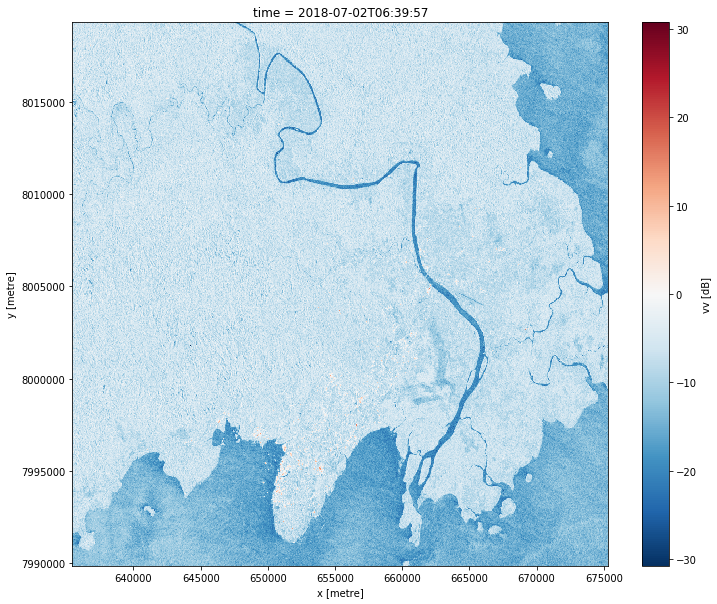

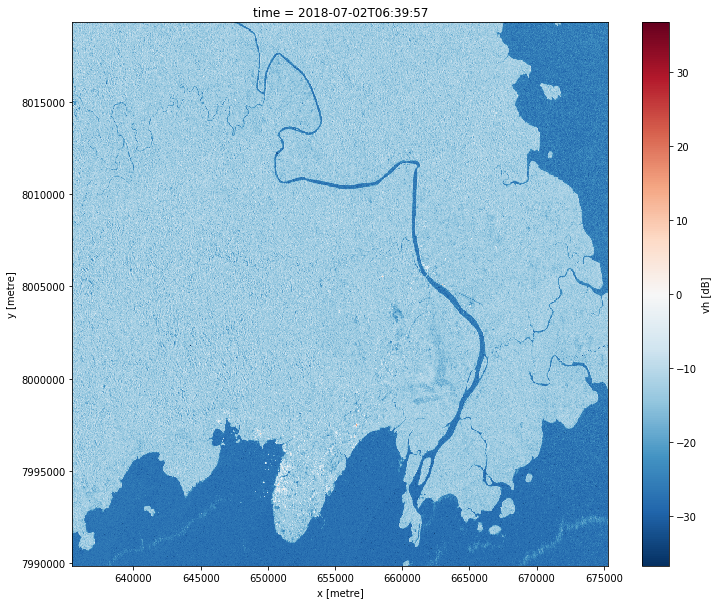

In [86]:
# # Plot output
s1_coverage.isel(time=15).vv.plot(figsize=(12, 10))
s1_coverage.isel(time=15).vh.plot(figsize=(12, 10))

In [81]:
# Create binary layer representing water (1) and non-water (0)
water = ((s1_coverage["vv"] <=12) & (s1_coverage["vh"] <= -15.5))

# Convert to Dataset and add name
water_cat_ds = water.to_dataset(name="water_cat").squeeze().drop('time')

In [46]:
water_cat_ds.isel(time=15).squeeze

<bound method DataWithCoords.squeeze of <xarray.Dataset>
Dimensions:    (x: 1329, y: 983)
Coordinates:
  * y          (y) float64 8.019e+06 8.019e+06 8.019e+06 ... 7.99e+06 7.99e+06
  * x          (x) float64 6.355e+05 6.355e+05 6.355e+05 ... 6.753e+05 6.753e+05
Data variables:
    water_cat  (y, x) bool False False False False False ... True True True True>

In [44]:
s1_coverage.isel(time=15).vh

<xarray.DataArray 'vh' (y: 983, x: 1329)>
array([[-13.073655, -11.577288, -12.227101, ..., -22.925226, -27.13955 ,
        -27.920338],
       [-13.760225, -10.954135, -10.803956, ..., -23.192604, -25.0924  ,
        -26.117535],
       [-13.786199, -13.152291, -12.216002, ..., -28.299381, -23.62211 ,
        -23.109982],
       ...,
       [-26.84466 , -26.682312, -26.248556, ..., -24.785803, -29.120344,
        -28.914053],
       [-27.877539, -26.154644, -27.175734, ..., -26.75319 , -28.721586,
        -29.437313],
       [-26.627869, -27.02373 , -27.84319 , ..., -28.40096 , -25.669847,
        -24.410582]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2018-07-02T06:39:57
  * y        (y) float64 8.019e+06 8.019e+06 8.019e+06 ... 7.99e+06 7.99e+06
  * x        (x) float64 6.355e+05 6.355e+05 6.355e+05 ... 6.753e+05 6.753e+05
Attributes:
    units:    dB
    nodata:   0
    crs:      EPSG:32760

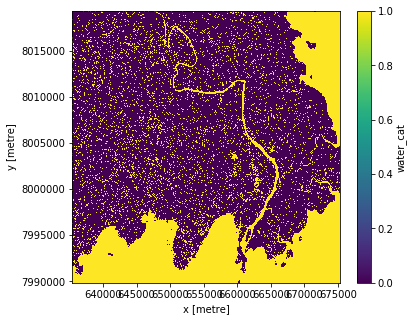

In [84]:
# # Plot output
water_cat_ds["water_cat"].isel(time=15).plot(figsize=(6, 5))

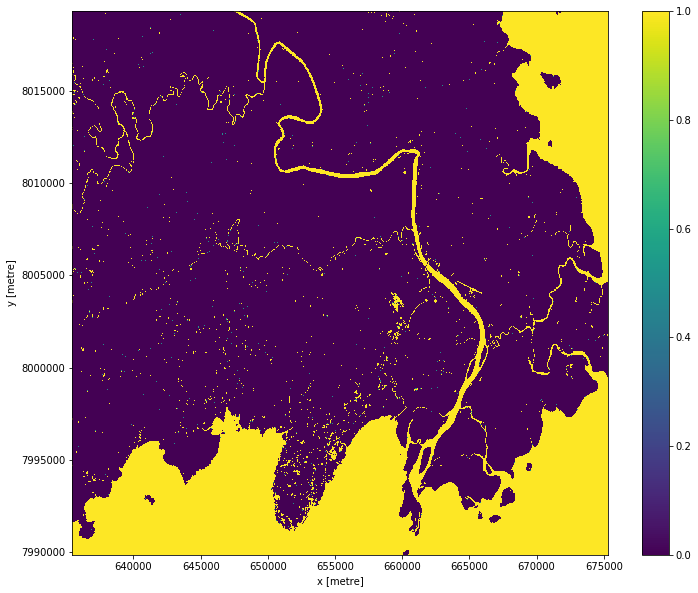

In [114]:
water.median(dim='time').plot(figsize=(12,10))

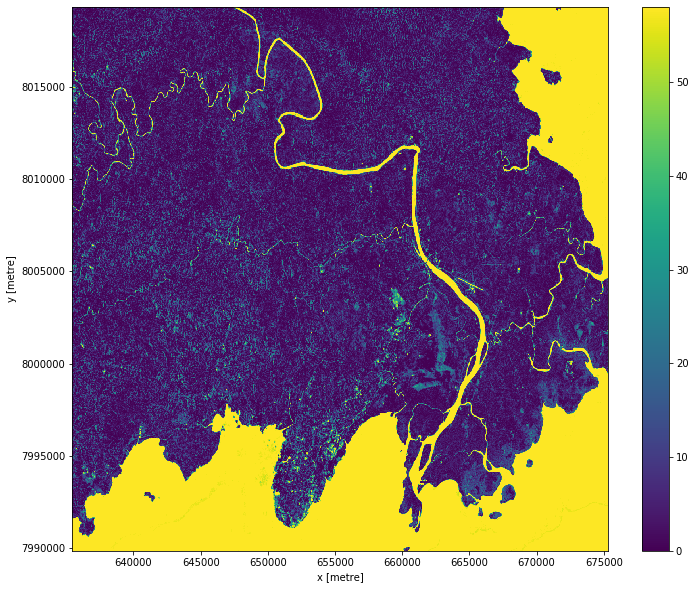

In [113]:
water.sum(dim='time').plot.imshow(figsize=(12,10))

In [148]:
#time to look at URBAN
# Create binary layer representing water (1) and non-water (0)
urban = ((s1_coverage["vv"] >=-2) | (s1_coverage["vh"] >=-5))

# Convert to Dataset and add name
urban_cat_ds = urban.to_dataset(name="urban_cat").squeeze().drop('time')

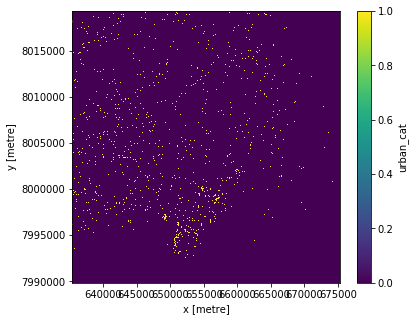

In [138]:
# # Plot output
urban_cat_ds["urban_cat"].isel(time=15).plot(figsize=(6, 5))

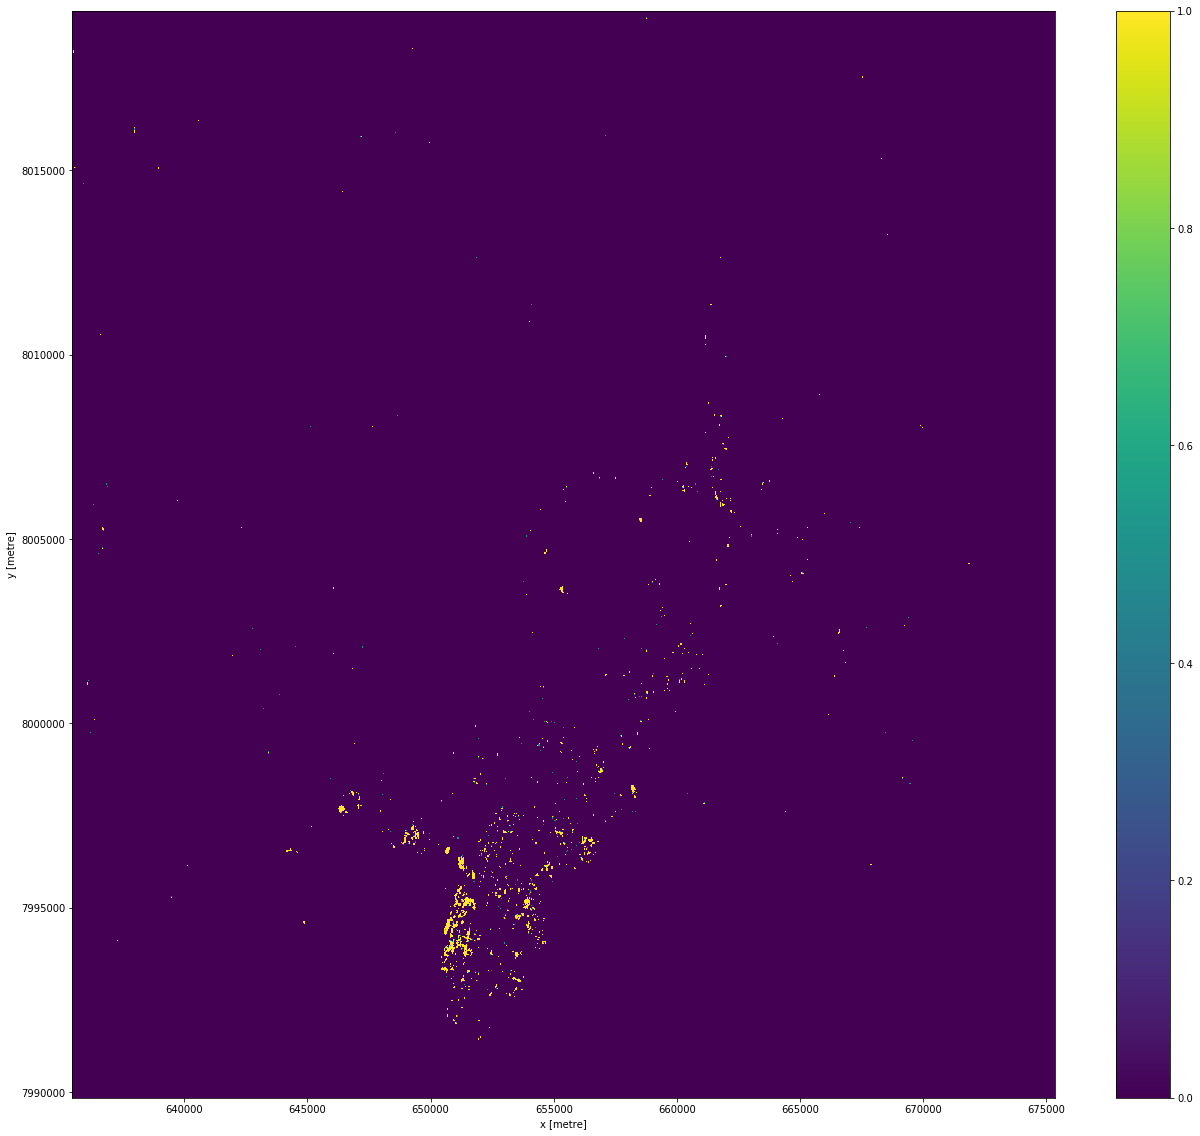

In [149]:
urban.median(dim='time').plot(figsize=(22,20))

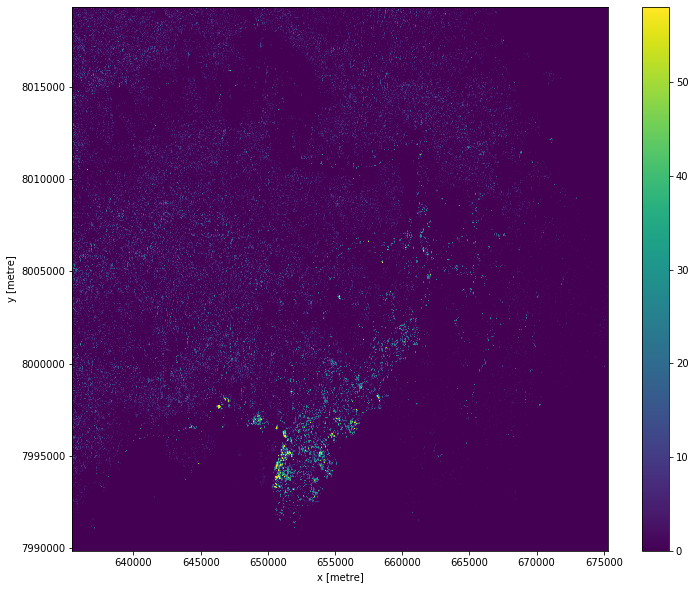

In [141]:
urban.sum(dim='time').plot.imshow(figsize=(12,10))

In [5]:
#time to distinguish vegetation from other types of cover
# Load data from datacube. So that the kernel doesn't crash, we are just going to load the red and NIR bands.
ls8_coverage_sr = dc.load(product="ls8_usgs_sr_scene", measurements=['red', 'nir'], output_crs ="EPSG:32760", **query)
ls8_coverage_sr = masking.mask_invalid_data(ls8_coverage_sr)

In [6]:
ls8_coverage_sr

<xarray.Dataset>
Dimensions:  (time: 53, x: 1329, y: 983)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-16T22:05:55.414623 ... 2019-03-18T22:06:36.782391
  * y        (y) float64 8.019e+06 8.019e+06 8.019e+06 ... 7.99e+06 7.99e+06
  * x        (x) float64 6.355e+05 6.355e+05 6.355e+05 ... 6.753e+05 6.753e+05
Data variables:
    red      (time, y, x) float64 458.0 316.0 493.0 437.0 ... 4.0 13.0 14.0 12.0
    nir      (time, y, x) float64 5.738e+03 5.557e+03 5.023e+03 ... 25.0 20.0
Attributes:
    crs:      EPSG:32760

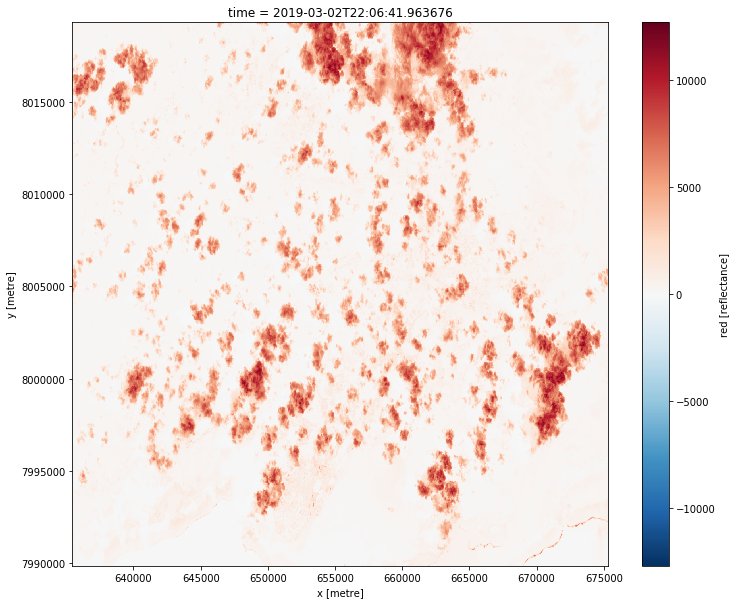

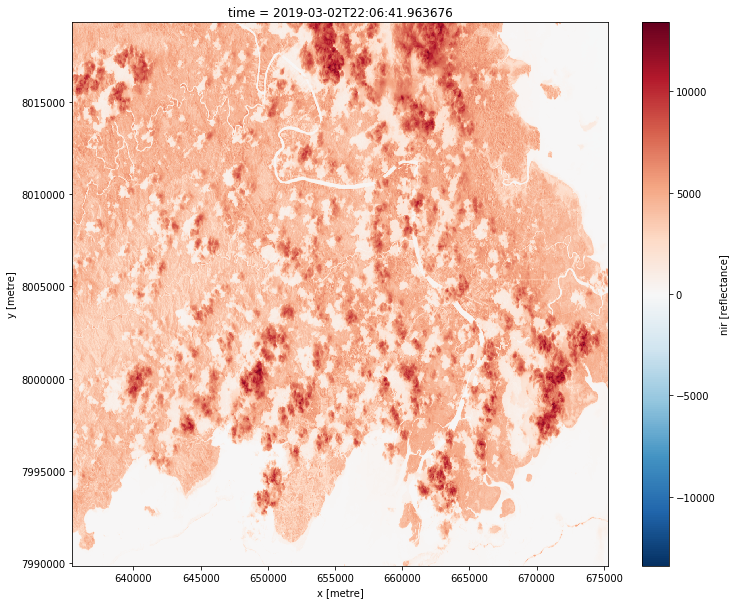

In [8]:
# # Plot output
ls8_coverage_sr.isel(time=50).red.plot(figsize=(12, 10))
ls8_coverage_sr.isel(time=50).nir.plot(figsize=(12, 10))

In [9]:
#define our NDVI
ndvi = ((ls8_coverage_sr.nir) - (ls8_coverage_sr.red))/((ls8_coverage_sr.nir) + (ls8_coverage_sr.red))

In [10]:
ndvi

<xarray.DataArray (time: 53, y: 983, x: 1329)>
array([[[ 8.521627e-01,  8.923889e-01, ...,  1.949861e-02,  4.453441e-02],
        [ 8.888326e-01,  9.133192e-01, ...,  4.184100e-03,  1.028037e-01],
        ...,
        [          nan,           nan, ..., -5.185185e-02, -2.040816e-02],
        [          nan,           nan, ..., -7.382550e-02, -5.343511e-02]],

       [[ 8.827171e-01,  9.379227e-01, ...,  1.595745e-02,  3.076923e-02],
        [ 9.240636e-01,  9.279886e-01, ..., -8.000000e-03,  7.317073e-02],
        ...,
        [ 1.343284e-01, -4.000000e-02, ..., -5.063291e-02, -2.352941e-02],
        [ 6.451613e-02,  1.250000e-01, ..., -7.142857e-02, -6.122449e-02]],

       ...,

       [[ 9.768151e-01,  9.828383e-01, ..., -1.144708e-01, -9.055118e-02],
        [ 9.499218e-01,  9.708307e-01, ..., -1.024590e-01, -9.363296e-02],
        ...,
        [          nan,           nan, ..., -2.325581e-02,  0.000000e+00],
        [          nan,           nan, ..., -1.515152e-02, -3.225806e-02

In [ ]:
ndvi.isel(time=20).plot(figsize=(12, 10))

### Aquatic or regularly flooded / Terrestrial

SECOND-LEVEL DISTINCTION
This layer breaks the initial veg/non-veg into 4 classes based on the presence or absence of water

   * *Primarily vegetated, Terrestrial*: The vegetation is influenced by the edaphic substratum
   * *Primarily Non-Vegetated, Terrestrial*: The cover is influenced by the edaphic substratum
   * *Primarily vegetated, Aquatic or regularly flooded*: The environment is significantly influenced by the presence of water over extensive periods of time. The water is the dominant factor determining natural soil development and the type of plant communities living on its surface
   * *Primarily Non-Vegetated, Aquatic or regularly flooded*:
   

Here we're using a Water Observations from Space (WOfS) annual summary to separate terrestrial areas from aquatic. We're using a threshold of 20% to rule out one-off flood events.

[WOfS](https://doi.org/10.1016/j.rse.2015.11.003)



**Creating your own layer**: To use a different veg/non-veg layer, replace the following two cells with code to create a binary layer with aquatic (1) and terrestrial (0), using the method of choice, and save into `aquatic_wat_cat_ds`

In [6]:
# Load data from datacube
wofs = dc.load(product="ls_usgs_wofs", output_crs=crs, **query)

wofs = masking.mask_invalid_data(wofs)

In [10]:
# Create binary layer representing aquatic (1) and terrestrial (0)
#aquatic_wat = ((wofs_ann["frequency"] >= 0.2))

# Convert to Dataset and add name
# aquatic_wat_cat_ds = aquatic_wat.to_dataset(name="aquatic_wat_cat").squeeze().drop('time')
aquatic_wat_cat_ds = wofs.isel(time=0).water

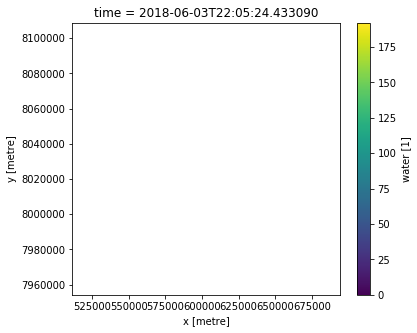

In [12]:
# # Plot output
aquatic_wat_cat_ds["water"].plot(figsize=(6, 5))

### cultman_agr_cat

TERTIARY-LEVEL DISTINCTION
This layer breaks the initial terrestrial and aquatic, vegetated categories into either cultivated/managed, or (semi-)natural

   * *Primarily vegetated, Terrestrial, Artificial/Managed*: Cultivated and Managed Terrestrial Areas
   * *Primarily vegetated, Terrestrial, (Semi-)natural*: Natural and Semi-Natural Vegetation
   * *Primarily vegetated, Aquatic or Regularly Flooded, Artificial/Managed*: Cultivated Aquatic or Regularly Flooded Areas
   * *Primarily vegetated, Aquatic or Regularly Flooded, (Semi-)natural*: Natural and Semi-Natural Aquatic or Regularly Flooded Vegetation

   

Here we're using the Median Absolute Deviation (MAD) to distinguish between natural and cultivated areas. This looks to be an interesting option, but more investigation is required to see if we can get a reliable, robust layer using this. 

In [9]:
# Load data from datacube
ls_mads = dc.load(product=sensor +"_nbart_tmad_annual", time=time, **query)
ls_mads = masking.mask_invalid_data(ls_mads)

In [10]:
# Create binary layer representing cultivated (1) and natural (0)
cultman = ((ls_mads["edev"] > 0.115))

# Convert to Dataset and add name
cultman_agr_cat_ds = cultman.to_dataset(name="cultman_agr_cat").squeeze().drop('time')

In [11]:
# # Plot output
# cultman_agr_cat_ds["cultman_agr_cat"].plot(figsize=(6, 5))

### artific_urb_cat

This layer breaks the initial terrestrial, non-vegetated category into either artificial surfaces or bare areas

   * *Primarily non-vegetated, Terrestrial, Artificial/managed*: Areas that have an artificial cover as a result of human activities such as construction, extraction or waste disposal
   * *Primarily non-vegetated, Terrestrial, (Semi-)natural*: Bare areas that do not have an artificial cover as a result of human activities. These areas include areas with less than 4% vegetative cover. Included are bare rock areas, sands and deserts   

Here we've used the Normalized Difference Built-up Index (NDBI), filtered by low NDVI to distinguish urban from bare soil. It doesn't do a great job and has issues classifying correctly in bright bare areas. 

In [12]:
# Load data
ls_gm = dc.load(product= sensor + "_nbart_geomedian_annual", time=time, **query)
ls_gm = masking.mask_invalid_data(ls_gm).squeeze().drop('time')

In [13]:
# Calculate ndvi
ndvi = ((ls_gm.nir - ls_gm.red) / (ls_gm.nir + ls_gm.red))

# Calculate NDBI
NDBI = ((ls_gm.nir - ls_gm.swir1) /  (ls_gm.nir + ls_gm.swir1))

In [23]:
# Create binary layer representing urban (1) and baresoil (0)
urban = (NDBI.where(ndvi<0.15) < 0)

# Convert to Dataset and add name
artific_urb_cat_ds = urban.to_dataset(name="artific_urb_cat")

In [15]:
# # Plot output
# artific_urb_cat["artific_urb_cat"].plot(figsize=(6, 5))

### artwatr_wat_cat

This layer breaks the initial Aquatic, non-vegetated category into either artificial water bodies or natural ones

   * *Primarily non-vegetated, Aquatic or Regularly Flooded, Artificial/managed*: areas that are covered by water due to the construction of artefacts such as reservoirs, canals, artificial lakes, etc.
   * *Primarily non-vegetated, Aquatic or Regularly Flooded, (Semi-)natural*: areas that are naturally covered by water, such as lakes, rivers, snow or ice

As differentiating between natural and artificial waterbodies using only satellite imagery is extremely difficult, here we use a static layer. Australian Hydrological Geospatial Fabric (Geofabric) is a dataset of hydrological features derived from manually interpreted topographic map grids. It classifies the land in terms of:  
0: Unclassified, 1: CanalArea, 2: Flat, 3: ForeshoreFlat, 4: PondageArea, 5: RapidArea, 6: WatercourseArea, 7: Lake, 8: Reservoir, 9: Swamp
Here, CanalArea & Reservoir are used to define artificial water.

In [16]:
# Load data
geofab = dc.load(product="geofabric",measurements=["band1"], **query)
geofab = geofab.squeeze().drop('time')

In [17]:
# # Plot data
# geofab.band1.plot.imshow(cmap="nipy_spectral")

In [18]:
# Create binary layer representing artificial water (1) and natural water (0)
artwatr_wat_cat_ds = ((geofab["band1"] == 1) | (geofab["band1"] == 8))

In [19]:
# Convert to Dataset and add name
artwatr_wat_cat_ds = artwatr_wat_cat_ds.to_dataset(name="artwatr_wat_cat")

In [20]:
# # Plot output
# artwatr_wat_cat_ds["artwatr_wat_cat"].plot(figsize=(5, 5))

Collect environmental variables into array for passing to classification system

In [24]:
variables_xarray_list = []
variables_xarray_list.append(artwatr_wat_cat_ds)
variables_xarray_list.append(aquatic_wat_cat_ds)
variables_xarray_list.append(vegetat_veg_cat_ds)
variables_xarray_list.append(cultman_agr_cat_ds)
variables_xarray_list.append(artific_urb_cat_ds)

## Classification

The LCCS classificaition is hierachial. The 8 classes are shown below.

| Class name | Code | Numeric code |
|----------------------------------|-----|-----|
| Cultivated Terrestrial Vegetated | A11 | 111 |
| Natural Terrestrial Vegetated | A12 | 112 |
| Cultivated Aquatic Vegetated | A23 | 123 |
| Natural Aquatic Vegetated | A24 | 124 |
| Artificial Surface | B15 | 215 |
| Natural Surface | B16 | 216 |
| Artificial Water | B27 | 227 |
| Natural Water | B28 | 228 |


In [25]:
# Merge to a single dataframe
classification_data = xarray.merge(variables_xarray_list)
#classification_data

In [26]:
# Apply Level 3 classification using separate function. Works through in three stages
level1, level2, level3 = lccs_l3.classify_lccs_level3(classification_data)

In [27]:
# Save classification values back to xarray
out_class_xarray = xarray.Dataset(
    {"level1" : (classification_data["vegetat_veg_cat"].dims, level1),
     "level2" : (classification_data["vegetat_veg_cat"].dims, level2),
     "level3" : (classification_data["vegetat_veg_cat"].dims, level3)})
classification_data = xarray.merge([classification_data, out_class_xarray])

col_level2 = cm.get_cmap("Set1", 2)
# classification_data.level2.plot(cmap=(col_level2))

In [28]:
# print("level 1:",numpy.unique(classification_data.level1))
# print("level 2:",numpy.unique(classification_data.level2))
# print("level 3:",numpy.unique(classification_data.level3))

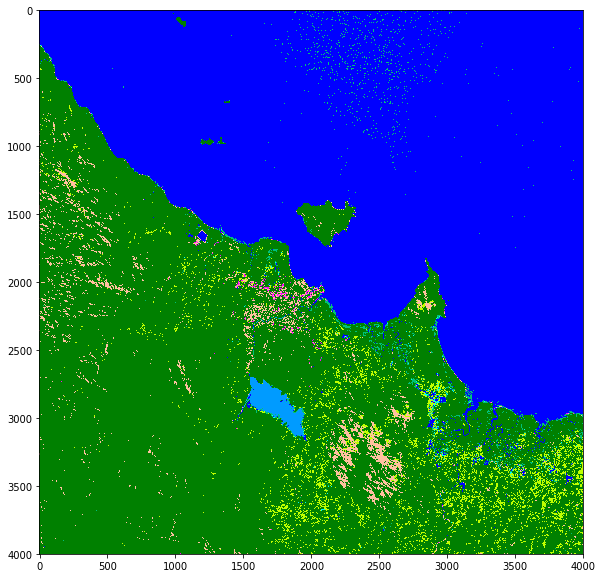

In [29]:
#To check the results for level 3 use colour_lccs_level3 to get the colour scheme.
pyplot.figure(figsize=(10, 10))
red, green, blue, alpha = lccs_l3.colour_lccs_level3(level3)
pyplot.imshow(numpy.dstack([red, green, blue, alpha]))

### Save results to geotiff

In [38]:
import gdal
def array_to_geotiff(fname, data, geo_transform, projection,
                     nodata_val=0, dtype=gdal.GDT_Int16):

    # Set up driver
    driver = gdal.GetDriverByName('GTiff')

    # Create raster of given size and projection
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, dtype)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)

    # Write data to array and set nodata values
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata_val)

    # Close file
    dataset = None

In [41]:
#create 'transform' tuple that will define the dimensions of the rasterized shapefile and exporty
import osr
srs = osr.SpatialReference()
srs.ImportFromEPSG(3577)
prj_wkt = srs.ExportToWkt()

easting = float(ls_gm.x[0])
W_E_pixelRes = float(ls_gm.y[0] - ls_gm.y[1])
rotation = 0.0 #(if image is 'north up')
northing = float(ls_gm.y[0])
rotation1 = 0.0 #(if image is 'north up')
N_S_pixelRes = float(ls_gm.x[0] - ls_gm.x[1])

transform = (easting, W_E_pixelRes, rotation, northing, rotation1, N_S_pixelRes)

array_to_geotiff(out_filename,
                  level3,
                  geo_transform = transform, 
                  projection = prj_wkt, 
                  nodata_val=0)